In [361]:
# Installing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os

sns.set_theme()


from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss


from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

In [192]:
# Loading the dataframe
filename = "dataframe_clean.pkl"
path = os.path.dirname(os.getcwd()) + "\\Data\\" + filename

df = pd.read_pickle(path)
df.head()

,order_id,customer_id,city,state,status,date_purchased,date_delivered,order_item_id,product_name,price,freight_value,review_score,comment
0,0,0,campos dos goytacazes,RJ,delivered,2017-09-13 08:00,2017-09-20 23:00,1,cool_stuff,58.9,13.29,5,NaN
1,1,1,santa fe do sul,SP,delivered,2017-04-26 10:00,2017-05-12 16:00,1,pet_shop,239.9,19.93,4,NaN
2,2,2,campinas,SP,delivered,2018-04-25 09:00,2018-04-30 17:00,1,consoles_games,639.0,11.34,4,NaN
3,3,3,cubatao,SP,delivered,2018-02-22 11:00,2018-03-12 18:00,1,cool_stuff,25.0,16.11,3,NaN
4,4,4,rio de janeiro,RJ,delivered,2017-09-11 17:00,2017-09-23 13:00,1,cool_stuff,48.9,16.60,5,NaN


In [193]:
df["sent_days"] = (df["date_delivered"] - df["date_purchased"]).apply(pd.Timedelta).dt.days

In [194]:
features_cat = ["state", "product_name"]
features_num = ["price", "freight_value", "sent_days"]

target = ["review_score"]

X_cat = df[features_cat]
X_num = df[features_num]

y = df[target]

In [195]:
enc = OneHotEncoder()
enc.fit(X_cat[["state","product_name"]])

df_cat = pd.DataFrame(enc.transform(X_cat[["state","product_name"]]).toarray(), columns=enc.get_feature_names_out())

In [196]:
X = X_num.join(df_cat, on=df_cat.index)

In [210]:
def train_val_test(X, y, train_size=0.8, test_size=0.15, random_state=42):
    
     X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
     X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1-train_size, random_state=random_state)
     
     return X_train, X_val, X_test, y_train, y_val, y_test

In [224]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(X, y, train_size=0.8, test_size=0.15, random_state=42)

In [325]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.98      0.96       776
           2       0.95      1.00      0.97       780
           3       0.94      0.97      0.96       744
           4       0.94      0.93      0.94       780
           5       0.99      0.87      0.92       695

    accuracy                           0.95      3775
   macro avg       0.95      0.95      0.95      3775
weighted avg       0.95      0.95      0.95      3775



In [326]:
importance_series_dtc = pd.Series({key: value for key,value in zip(dtc.feature_names_in_, dtc.feature_importances_)})

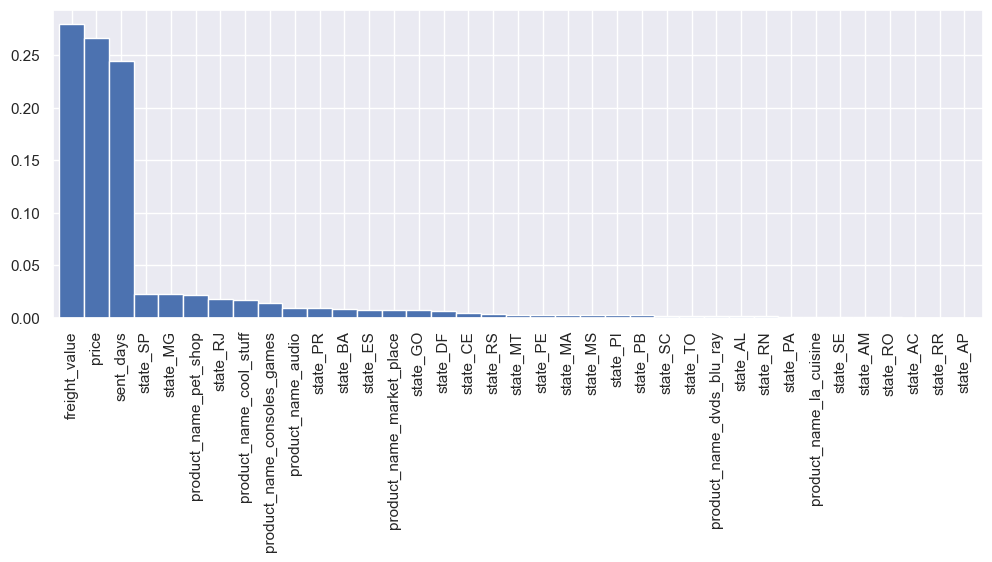

In [327]:
importance_series_dtc.sort_values(ascending=False).plot(kind="bar", figsize=(12,4), width=1);

## Hyperparameter tuning for the Decision Tree Classifier

In [267]:
# Creating the hyperparameter grid
param_dist = {"max_depth": [3, None],
              "max_features": range(1,11),
              "min_samples_leaf": range(1, 11),
              "criterion": ["gini", "entropy", "log_loss"]}


# Instantiation of the tree
dtc = DecisionTreeClassifier()


# Instantiating RandomizedSearchCV object
tree_cv = GridSearchCV(dtc, param_dist, cv = 5)
 
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 1}
Best score is 0.8270745543127521


In [275]:
tree_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [328]:
dtc = DecisionTreeClassifier(criterion = tree_cv.best_params_["criterion"],
                             max_depth = tree_cv.best_params_["max_depth"],
                             max_features = tree_cv.best_params_["max_features"],
                             min_samples_leaf = tree_cv.best_params_["min_samples_leaf"])
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.98      0.96       776
           2       0.95      1.00      0.97       780
           3       0.95      0.97      0.96       744
           4       0.94      0.93      0.94       780
           5       0.99      0.87      0.92       695

    accuracy                           0.95      3775
   macro avg       0.95      0.95      0.95      3775
weighted avg       0.95      0.95      0.95      3775



## Random Forest

In [329]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train.values.ravel())

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.98      0.96       776
           2       0.95      1.00      0.97       780
           3       0.95      0.97      0.96       744
           4       0.95      0.93      0.94       780
           5       0.98      0.88      0.93       695

    accuracy                           0.95      3775
   macro avg       0.95      0.95      0.95      3775
weighted avg       0.95      0.95      0.95      3775



### Support Vector Machines

In [340]:
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train.values.ravel())

y_pred = clf.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.25      0.21      0.23      3513
           2       0.22      0.53      0.31      3592
           3       0.21      0.33      0.26      3563
           4       0.24      0.02      0.04      3531
           5       0.29      0.01      0.03      3565

    accuracy                           0.22     17764
   macro avg       0.24      0.22      0.17     17764
weighted avg       0.24      0.22      0.17     17764



In [349]:
dir(classification_report(y_train, y_pred))

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'removeprefix',
 'removesuffix',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'stri

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

list_acc = []
list_pre = []
list_rec = []
list_f1s = []
list_roc = []
list_log = []


for n_neighbors in range(1,101):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train.values.ravel())
    
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)

    list_acc.append(accuracy_score(y_test, y_pred))
    list_log.append(log_loss(y_test, y_pred_prob))
    list_pre.append(precision_score(y_test, y_pred, average=None))
    list_rec.append(recall_score(y_test, y_pred, average=None))
    list_f1s.append(f1_score(y_test, y_pred, average=None))
    list_roc.append(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))